# Ligand-Receptor Inference

As a result of the growing interest in cell-cell communication (CCC) inference, a number of computational tools in single-cell transcriptomics have emerged. Although, there many different categories and approaches to infer CCC events, in this tutorial we will focus on those that infer interactions between ligands and receptors, commonly referred to as ligand-receptor (LR) inference methods (e.g. ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Hou et al., 2020](https://www.nature.com/articles/s41467-020-18873-z), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Raredon et al., 2022](https://www.nature.com/articles/s41598-022-07959-x)). These tools typically rely on gene expression information as a proxy of protein abundance, and they work downstream of data pre-processing and acquisition of biologically-meaningful cell groups. These CCC tools infer intercellular interactions in a hypothesis-free manner, meaning that they infer all possible interactions between cell clusters, relying on prior knowledge of the potential interactions. Here, one group of cells is considered the source of the communication signal, sending a ligand, and the other is the receiver of the signal via its receptors. CCC events are thus represented as interactions between LR pairs, expressed by any combination of source and receiver cell groups.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of LR methods, the interactions can also be represented by heteromeric protein complexes ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x)). 

Here, we will use LIANA to obtain a consensus score for each LR interaction inferred by the different tools. Further, we will make use of LIANA's consensus resource, which combines a number of expert-curated LR resources.

## Environment Setup

In [1]:
library(Seurat, quietly = T)
library(liana, quietly = T)
library(dplyr, quietly = T)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Directories

In [2]:
data.path = '/data/hratch/ccc_protocols/interim/' #'../../data/' #<-uncomment in final
output_folder = paste0(c(data.path, 'liana-outputs/'))

## Data Reminder

Here, we will re-load the processed data as processed in Tutorial 01.

**Change this to reading directly from Seurat once tutorial 01 in R is fully completed**

In [3]:
covid_data<-readRDS(paste0(data.path, 'covid_balf_norm.rds'))

just as a quick reminder, let's visualize the cell types and samples in the data.

In [4]:
head(covid_data@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample,sample_new,disease,hasnCoV,cluster,cell.type,condition,percent.mt
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
AAACCCACAGCTACAT-1_1,C100,3123,1376,C100,HC3,N,N,27,B,Control,9.1869398
AAACCCATCCACGGGT-1_1,C100,1429,835,C100,HC3,N,N,23,Macrophages,Control,0.9090909
AAACCCATCCCATTCG-1_1,C100,2342,1105,C100,HC3,N,N,6,T,Control,6.3193851
AAACGAACAAACAGGC-1_1,C100,31378,4530,C100,HC3,N,N,10,Macrophages,Control,9.9815157
AAACGAAGTCGCACAC-1_1,C100,12767,3409,C100,HC3,N,N,10,Macrophages,Control,5.1617451
AAACGAAGTCTATGAC-1_1,C100,2198,1094,C100,HC3,N,N,9,T,Control,8.8717015


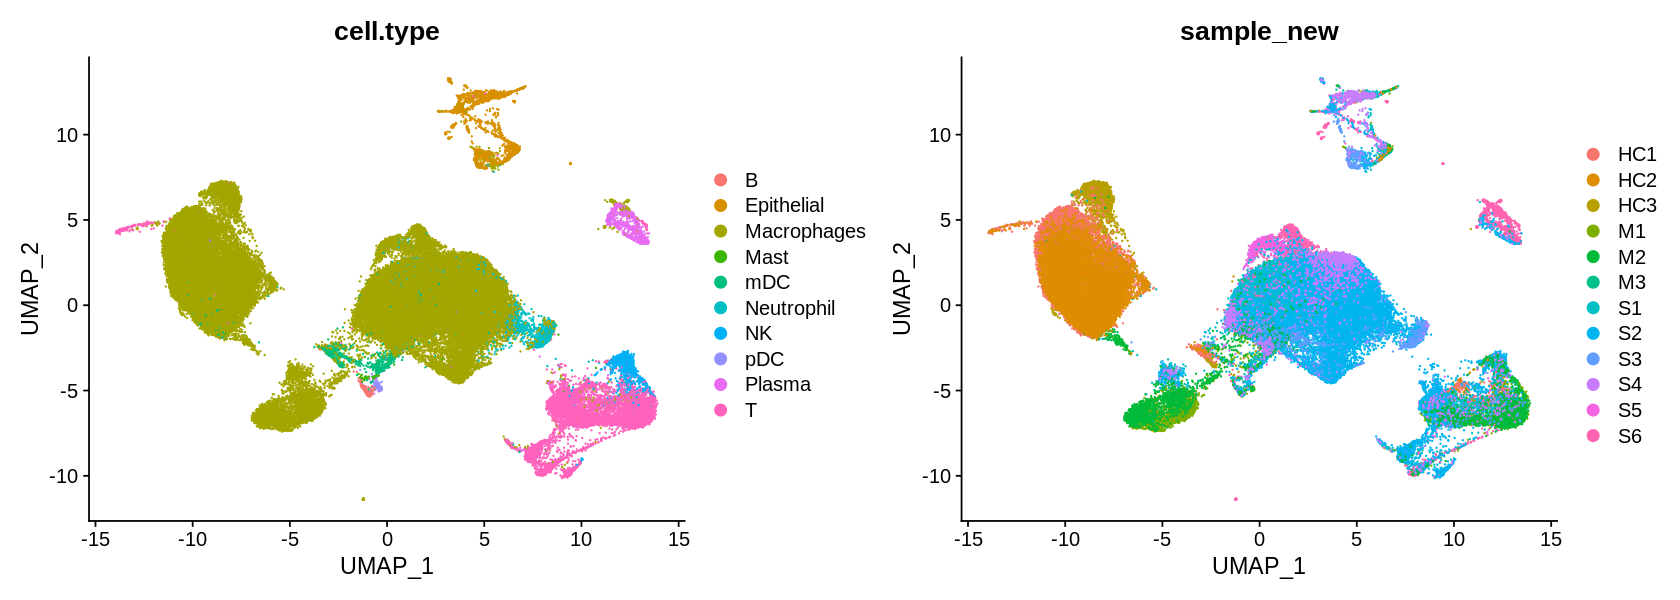

In [5]:
# plot pre-annotated cell types
h_ = 5
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

Idents(covid_data)<-'cell.type'
plot1<-DimPlot(covid_data, reduction = "umap", group.by = 'cell.type')
plot2<-DimPlot(covid_data, reduction = "umap", group.by = 'sample_new')

plot1 + plot2

## Predicting CCC events with LIANA

Now that we have the preprocessed data loaded, we will use liana to score the interactions inferred by the different tools.

`liana` is highly modularized and it implements a number of methods to score LR interactions, we can list those with the following command: 

In [6]:
liana::show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

liana classifies interaction scores into two categories: those that infer the **Magnitude** and **Specificity** of interactions. The **Magnitude** of an interactions is a measure of the strength of the interaction's expression, and the **Specificity** of an interaction is a measure of how specific is an interaction to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score is likely to be specific, and vice versa. 

### UPDATE LIANA'S DIAGRAM

## Scoring Functions

We will now describe the mathematical formulation of the magnitude and specificity scores we will use in this tutorial:

### Shared Notations


`k` is the k-th ligand-receptor interaction 

`L` - expression of ligand L

`R` - expression of receptor R

`C` - cell cluster

`i` - cell group i

`j` - cell group j

`M` - the library-size normalized and log1p-transformed gene expression matrix

`X` - normalized gene expression vector

### CellPhoneDBv2
**Magnitude**: 
<img src="./../../Figures/scoring_functions/lr_mean.svg" alt="" class="bg-primary mb-1" width="250px">

**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.


### Geometric Mean
**Magnitude**:
![lr_means](../../figures/scoring_functions/lr_gmean.svg);

where GeometricMean is calculated as follows:

![geometric_mean](../../figures/scoring_functions/geometric_mean.svg)


**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

### CellChat

**Magnitude**:
![lr_prob](../../figures/scoring_functions/lr_prob.svg)

where `TriMean` represents Tuckey's Trimean function:

![trimean](../../figures/scoring_functions/trimean.svg)

Note that the original CellChat implementation also uses information of mediator proteins, which is specific to the CellChat resource.
Since we are using the consensus resource, we will not use this information, and hence the implementation of CellChat's `LR_probability` in LIANA is simplified to be resource-agnostic.

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

##### The specificity scores of these three method is calculated as follows:

![lr_permutation](../../figures/scoring_functions/lr_permutation.svg)

where `P` is the number of permutations, and `L*` and `R*` are ligand and receptor expression summarized according by each method, i.e. `arithmetic mean` for CellPhoneDB, `TriMean` for CellChat, and `geometric mean` for Geometric Mean.

### SingleCellSignalR

**Magnitude**:
![lrscore](../../figures/scoring_functions/lr_score.svg)

where `mu` is the mean of the expression matrix `M`

### NATMI

**Magnitude**:
![lr_product](../../figures/scoring_functions/lr_product.svg)

**Specificity**:
![specificity_weight](../../figures/scoring_functions/specificity_weight.svg)

### Connectome

**Magnitude**:
![lr_product](../../figures/scoring_functions/lr_product.svg)

**Specificity**:
![zmean](../../figures/scoring_functions/zmean.svg)

where `z` is the z-score of the expression matrix `M`:

![zscore](../../figures/scoring_functions/zscore.svg)

### log2FC

**Specificity**:
![lr_log2fc](../../figures/scoring_functions/lr_log2fc.svg)

where log2FC for each gene is calculated as:

![log2fc](../../figures/scoring_functions/log2fc.svg)


What the above equations show is that there are many commonalities between the different methods, yet there are also many variations in the way the magnitude and specificity scores are calculated. 

![expr_indicator](../../figures/scoring_functions/expr_indicator.svg)

where liana considers interactions as occurring only if the ligand and receptor, and any of their subunits, are expressed in the cell clusters `i`, `j`.
Any interactions that don't pass these criteria are not returned by default, to return them the user can check the `return_all_lrs` parameter.

### Score Distributions

In [7]:
# pick a sample to infer the communication scores for
sdata = subset(x = covid_data, subset = sample == 'C100')
sdata

An object of class Seurat 
24798 features across 2550 samples within 1 assay 
Active assay: RNA (24798 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

The parameters that we will use are the following:
- `idents_col` is the column in the `meta` dataframe that contains the cell groups
- `assay` is a string that indicates which Seurat assay to use (typically `RNA`, unless having done a batch correction step)
- `assay.type` is a string that indicates whether to use the raw (`counts`) or log- and library-normalized (`logcounts`) counts attribute of the Seurat object assay.
- `expr_prop` is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a ligand-receptor pair
- `verbose` is a boolean that indicates whether to print the progress of the function

(Other parameters are described in the documentation of the function, as well as in more detail below)

**Fix this:** assay.type = 'counts' does not work

In [9]:
liana_res <- liana_wrap(sce = sdata, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                      expr_prop=0.1, verbose=T, parallelize = T, workers = 30)

Expression from the `RNA` assay will be used

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: Plasma were removed!

Warning message in exec(output, ...):
“5591 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once per session.”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Warning message:
“`progress_estimated()` was deprecated in dplyr 1.0.0.
ℹ The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>.”


liana returns a list of results, each element of which corresponds to a method

In [10]:
liana_res %>% dplyr::glimpse()

List of 5
 $ natmi      : tibble [9,911 × 14] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ target          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ ligand.complex  : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ ligand          : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ receptor.complex: chr [1:9911] "LILRB1" "LILRB1" "ITGAX_ITGB2" "CR2" ...
  ..$ receptor        : chr [1:9911] "LILRB1" "LILRB1" "ITGAX" "CR2" ...
  ..$ receptor.prop   : num [1:9911] 0.111 0.111 0.111 0.111 0.111 ...
  ..$ ligand.prop     : num [1:9911] 0.889 0.778 0.222 0.222 0.222 ...
  ..$ ligand.expr     : num [1:9911] 2.522 2.043 0.377 0.377 0.34 ...
  ..$ receptor.expr   : num [1:9911] 0.237 0.237 0.345 0.173 0.173 ...
  ..$ ligand.sum      : num [1:9911] 19.296 19.192 0.381 0.381 2.687 ...
  ..$ receptor.sum    : num [1:9911] 1.321 1.321 4.268 0.173 0.463 ...
  ..$ prod_weight     : num [1:9911] 0.5985 0.4848 0.1304 0.0652 0.0588 ...
  ..$ edge_

To provide a better illustration of the different scores, we will now plot the distribution of scores for each of the methods.

First, we format the scores to resemble those in lianapy:

In [11]:
format_res<-function(liana_res){
    stop('Need to double check mappings')
    cols.retain<-list(natmi = c('prod_weight', 'edge_specificity'), 
                 connectome = c('weight_sc'), 
                 logfc = c('logfc_comb'),
                 sca = c('LRscore'), 
                 cellphonedb = c('lr.mean', 'pvalue'))
    cols.map<-list(natmi = c('expr.prod', 'spec.weight'), 
                     connectome = c('scaled.weight'), 
                     logfc = c('lr_logfc'),
                     sca = c('lrscore'), 
                     cellphonedb = c('lr_means', 'cellphone_pvals'))
    same.cols<-c('source', 'target', 'ligand.complex', 'receptor.complex')

    liana_res.formatted<-list()
    for (score.method in names(liana_res)){
        liana.sm<-liana_res[[score.method]]
        liana.sm<-liana.sm[c(same.cols, cols.retain[[score.method]])]
        colnames(liana.natmi)<-c(same.cols, cols.map[[score.method]])
        liana_res.formatted[[score.method]]<-liana.sm
    }

    consistent.same.cols<-all(apply(combn(length(check.dims), 2), 2, function(x) identical(check.dims[[x[1]]], check.dims[[x[2]]])))
    if (!consistent.same.cols){
        stop('Cannot format as in lianapy because scoring methods have inconsistent interaction types')
    }
    
}



This show the extent to which  each of the scoring functions differ from each other. Unsurprisingly, independent evaluations have shown that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools ([Dimitrov et al., 2022](https://www.nature.com/articles/s41467-022-30755-0), [Liu et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02783-y), [Wang et al., 2022](https://academic.oup.com/bfg/article/21/5/339/6640320)). To this end, we have implemented a consensus score that is a rank aggregate of the scores obtained by the different methods, and for the sake of these tutorials we will use this consensus score to rank the interactions, specifically the one that aggregates the magnitude scores from different functions.

### LIANA's Rank Aggregate

LIANA calculates an aggregate rank for both `magnitude` and `specificity` as defined above. The `rank_aggregate` function of liana uses a re-implementation of the RobustRankAggregate method by [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/), and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis. It thus provides a consensus of the rank of the ligand-receptor interactions across methods, that can also be treated as a p-value.

In more detail, a rank aggregate is calculated for the `magnitude` and `specificity` scores from the methods in LIANA as follows:

First, a normalized rank matrix[0,1] is generated separately for magnitude and specificity as:

![normalized_rank](../../Figures/scoring_functions/normalized_rank.svg)

where `m` is the number of score rank vectors, `n` is the length of each score vector (number of interactions), **rank<sub>i,j</sub>** is the rank of the `j-th` element (interaction) in the `i-th` score rank vector, and **max(rank<sub>i</sub>)** is the maximum rank in the `i-th` rank vector.

For each normalized rank vector `r`, we then ask how probable is it to obtain **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>**, where **r<sup>null</sup><sub>(k)</sub>** is a rank vector generated under the null hypothesis. The RobustRankAggregate method expresses [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/) the probability **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>** as **β<sub>k,n</sub>(r)**, through a beta distribution. 
This entails that we obtain probabilities for each score vector `r` as:

![rra_pvals](../../Figures/scoring_functions/rra_pvals.svg)

where we take the minimum probability `ρ` for each interaction across the score vectors, and we apply a Bonferroni correction to the p-values by multiplying them by `n` to account for multiple testing.

In [13]:
liana_aggregate <- liana_res %>% liana_aggregate()

Now aggregating natmi

Now aggregating connectome

Now aggregating logfc

Now aggregating sca

Now aggregating cellphonedb

Aggregating Ranks

